# VPIN Indicator Analysis

Volume-Synchronized Probability of Informed Trading (VPIN) analysis using CoinGecko data and Rust indicators.

In [16]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import rust_indicators
from pycoingecko import CoinGeckoAPI
import warnings
warnings.filterwarnings('ignore')

# Initialize
cg = CoinGeckoAPI()
ta = rust_indicators.RustTA()
print(f"✓ Backend: {ta.device()}")

✓ Backend: cpu


## 1. Data Collection & VPIN Calculation

In [17]:
def fetch_and_prepare_data(coin_id='bitcoin', days=7):
    """Fetch crypto data and generate buy/sell volumes"""
    data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=days)
    
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df['volume'] = pd.DataFrame(data['total_volumes'])[1]
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Generate buy/sell volumes based on price momentum
    price_changes = df['price'].pct_change().fillna(0)
    buy_ratio = 0.5 + 0.3 * np.tanh(price_changes / price_changes.std())
    
    df['buy_volume'] = df['volume'] * buy_ratio
    df['sell_volume'] = df['volume'] * (1 - buy_ratio)
    
    return df

# Fetch data and calculate VPIN
df = fetch_and_prepare_data('bitcoin', days=7)
windows = [20, 50, 100]

for w in windows:
    df[f'vpin_{w}'] = ta.vpin(df['buy_volume'].values, df['sell_volume'].values, w)

print(f"Data: {len(df)} points from {df['datetime'].min()} to {df['datetime'].max()}")
display(df.head())

Data: 168 points from 2025-09-10 00:01:58.797000 to 2025-09-16 23:51:25


,timestamp,price,volume,datetime,buy_volume,sell_volume,vpin_20,vpin_50,vpin_100
0,1757462518797,111521.544232,4.554139e+10,2025-09-10 00:01:58.797,2.277070e+10,2.277070e+10,0.0,0.0,0.0
1,1757466141837,111062.111732,4.497880e+10,2025-09-10 01:02:21.837,9.851861e+09,3.512694e+10,0.0,0.0,0.0
2,1757469705193,111023.099571,4.462624e+10,2025-09-10 02:01:45.193,2.037568e+10,2.425056e+10,0.0,0.0,0.0
3,1757473235162,111397.550743,4.466058e+10,2025-09-10 03:00:35.162,3.419048e+10,1.047010e+10,0.0,0.0,0.0
4,1757476940585,111525.927139,4.437020e+10,2025-09-10 04:02:20.585,2.810519e+10,1.626501e+10,0.0,0.0,0.0


## 2. VPIN Visualization

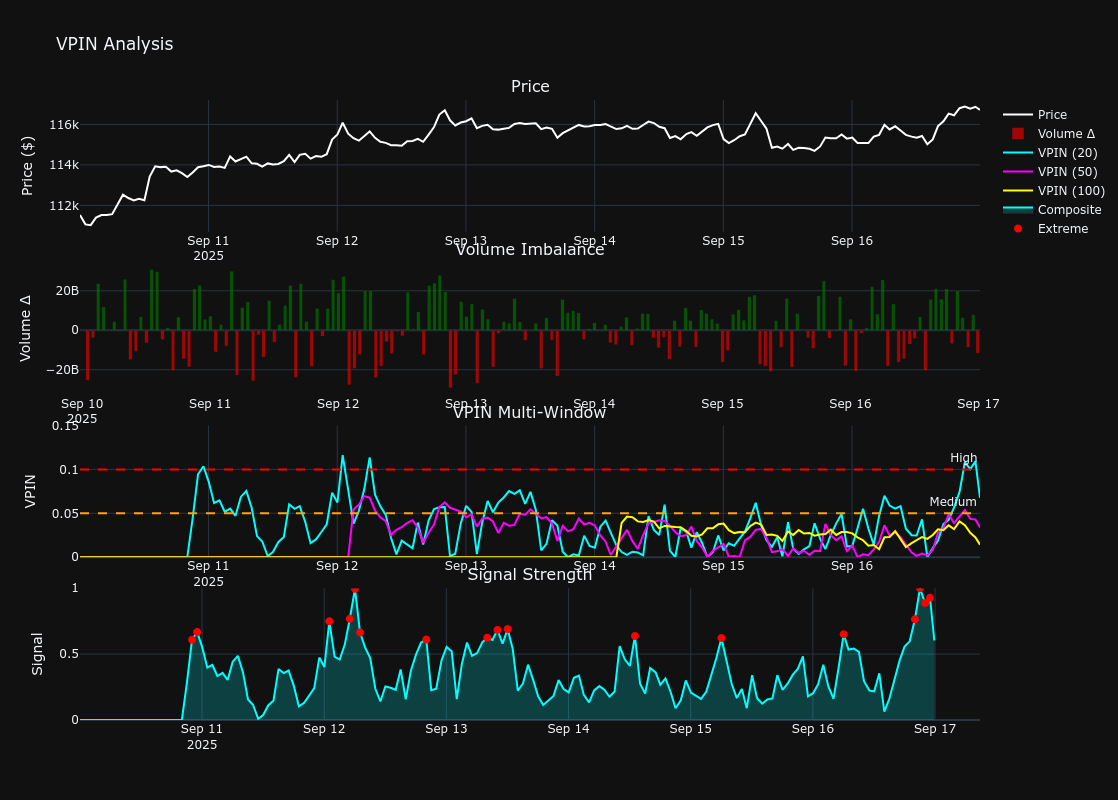

In [18]:
def plot_vpin_analysis(df):
    fig = make_subplots(
        rows=4, cols=1,
        row_heights=[0.25, 0.25, 0.25, 0.25],
        subplot_titles=['Price', 'Volume Imbalance', 'VPIN Multi-Window', 'Signal Strength'],
        vertical_spacing=0.05
    )
    
    # 1. Price
    fig.add_trace(go.Scatter(x=df['datetime'], y=df['price'], name='Price', line=dict(color='white')), row=1, col=1)
    
    # 2. Volume imbalance
    volume_imbalance = df['buy_volume'] - df['sell_volume']
    colors = ['green' if x > 0 else 'red' for x in volume_imbalance]
    fig.add_trace(go.Bar(x=df['datetime'], y=volume_imbalance, marker_color=colors, opacity=0.6, name='Volume Δ'), row=2, col=1)
    
    # 3. Multi-window VPIN
    colors_vpin = ['cyan', 'magenta', 'yellow']
    for i, w in enumerate([20, 50, 100]):
        fig.add_trace(go.Scatter(x=df['datetime'], y=df[f'vpin_{w}'], name=f'VPIN ({w})', 
                                line=dict(color=colors_vpin[i])), row=3, col=1)
    
    # Add thresholds
    fig.add_hline(y=0.1, line_dash="dash", line_color="red", annotation_text="High", row=3, col=1)
    fig.add_hline(y=0.05, line_dash="dash", line_color="orange", annotation_text="Medium", row=3, col=1)
    
    # 4. Composite signal
    signal = (df['vpin_20'] * 0.5 + df['vpin_50'] * 0.3 + df['vpin_100'] * 0.2)
    signal_norm = (signal - signal.min()) / (signal.max() - signal.min())
    
    fig.add_trace(go.Scatter(x=df['datetime'], y=signal_norm, fill='tozeroy', 
                            fillcolor='rgba(0,255,255,0.2)', line=dict(color='cyan'), 
                            name='Composite'), row=4, col=1)
    
    # Extreme events
    extremes = signal_norm > signal_norm.quantile(0.9)
    fig.add_trace(go.Scatter(x=df[extremes]['datetime'], y=signal_norm[extremes], 
                            mode='markers', marker=dict(color='red', size=8), 
                            name='Extreme'), row=4, col=1)
    
    fig.update_layout(height=800, title="VPIN Analysis", template="plotly_dark")
    fig.update_yaxes(title="Price ($)", row=1, col=1)
    fig.update_yaxes(title="Volume Δ", row=2, col=1)
    fig.update_yaxes(title="VPIN", row=3, col=1, range=[0, 0.15])
    fig.update_yaxes(title="Signal", row=4, col=1, range=[0, 1])
    
    return fig

fig = plot_vpin_analysis(df)
fig.show()

## 3. VPIN Heatmap

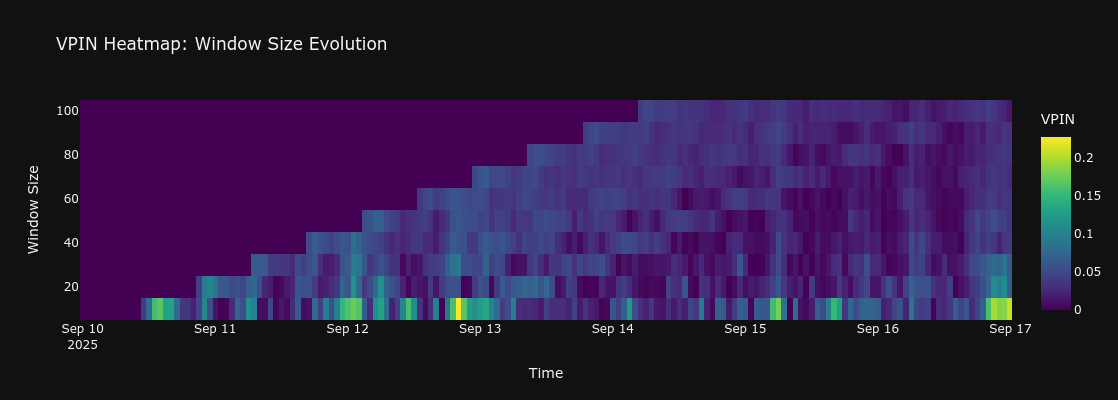

In [19]:
def create_vpin_heatmap(df):
    windows = range(10, 101, 10)
    heatmap_data = []
    
    for w in windows:
        vpin = ta.vpin(df['buy_volume'].values, df['sell_volume'].values, w)
        heatmap_data.append(vpin)
    
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data, x=df['datetime'], y=list(windows),
        colorscale='Viridis', colorbar=dict(title="VPIN")
    ))
    
    fig.update_layout(
        title="VPIN Heatmap: Window Size Evolution",
        xaxis_title="Time", yaxis_title="Window Size",
        height=400, template="plotly_dark"
    )
    
    return fig

heatmap = create_vpin_heatmap(df)
heatmap.show()

## 4. Key Insights

In [20]:
def create_insights_dashboard(df):
    vpin_20 = df['vpin_20'].dropna()
    high_activity = (vpin_20 > vpin_20.quantile(0.8)).sum() / len(vpin_20) * 100
    
    price_returns = df['price'].pct_change()
    vpin_correlation = vpin_20.corr(price_returns.abs().iloc[20:])
    
    current_vpin = vpin_20.iloc[-1]
    current_signal = 'HIGH' if current_vpin > vpin_20.quantile(0.8) else 'NORMAL'
    if current_vpin > vpin_20.quantile(0.95):
        current_signal = 'EXTREME'
    
    print("="*50)
    print("VPIN ANALYSIS INSIGHTS")
    print("="*50)
    print(f"📊 High Activity Periods: {high_activity:.1f}% of time")
    print(f"📈 VPIN-Volatility Correlation: {vpin_correlation:.3f}")
    print(f"⚡ Max VPIN (20): {vpin_20.max():.4f}")
    print(f"📉 Mean VPIN (20): {vpin_20.mean():.4f}")
    print(f"🎯 Current VPIN: {current_vpin:.4f}")
    print(f"🚨 Current Signal: {current_signal}")
    print("="*50)
    
    # Statistics table
    stats_data = []
    for w in [20, 50, 100]:
        vpin_col = df[f'vpin_{w}'].dropna()
        stats_data.append({
            'Window': w,
            'Mean': vpin_col.mean(),
            'Max': vpin_col.max(),
            'Q95': vpin_col.quantile(0.95)
        })
    
    stats_df = pd.DataFrame(stats_data)
    print("\nVPIN Statistics:")
    display(stats_df.round(4))

create_insights_dashboard(df)

VPIN ANALYSIS INSIGHTS
📊 High Activity Periods: 20.2% of time
📈 VPIN-Volatility Correlation: 0.043
⚡ Max VPIN (20): 0.1163
📉 Mean VPIN (20): 0.0331
🎯 Current VPIN: 0.0676
🚨 Current Signal: HIGH

VPIN Statistics:


,Window,Mean,Max,Q95
0,20,0.0331,0.1163,0.0770
1,50,0.0201,0.0697,0.0543
2,100,0.0117,0.0463,0.0388
